# US Name

Estimate tfp_OP_f as a function of  asset_tangibility and others (Estimate table 6 with TFP) 

# Business needs 

Estimate tfp_OP_f as a function of  asset_tangibility, cash_over_total_asset, credit constraint, current ratio, sales over asset Andersen method, liabilities over asset (Estimate table 6 by using TFP instead of asset tangibility to explain a new channel of impact) 

## Description
### Objective 

Test the coefficient sign and significant of the main variable

### Tables

Table 1: Baseline Estimate, tfp_OP_f and asset_tangibility, cash_over_total_asset, credit constraint, current ratio, sales over asset Andersen method, liabilities over asset

**Cautious**
Make sure no empty rows, otherwise it will be filtered out in the estimate


# Metadata

- Key: rae81txps49928f
- Epic: Models
- US: Estimate TFP
- Task tag: #analytics, #andersen, #tfp, #econometrics
- Analytics reports: 

# Input Cloud Storage

## Table/file

**Name** 

- https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/09_asif_tfp_firm_baseline.md

**Github**

- DATA/ECON/FIRM_SURVEY/ASIF_CHINA/TRANSFORMED/TFP/CREDIT_CONSTRAINT



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-3'
bucket = 'datalake-datascience'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [5]:
db = 'firms_survey'
table = 'asif_tfp_credit_constraint'

In [6]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [7]:
download_data = True
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalogue/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT * 
    FROM {}.{}
    WHERE 
    cashflow_to_tangible > 0
    AND current_ratio > 0
    AND liabilities_tot_asset > 0
    AND year in (
        '2001', '2002', '2003', '2004', '2005', 
        '2006', '2007'
      )
    """.format(db, table)
    df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename=filename,  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
            )
    s3.download_file(
        key = full_path_filename
    )
    shutil.move(
        filename + '.csv',
        os.path.join(path_local, filename + '.csv')
    )
    s3.remove_file(full_path_filename)
    df.head()

In [8]:
pd.DataFrame(schema)

,Name,Type,Comment
0,firm,string,firm ID
1,year,string,year
2,period,varchar(5),if year prior to 2006 then False else true. Indicate break from 10 and 11 FYP
3,cic,string,4 digits industry code
4,indu_2,string,"Two digits industry. If length cic equals to 3, then add 0 to indu_2"
...,...,...,...
73,count_city,string,
74,count_industry,string,
75,fe_c_i,bigint,City industry fixed effect
76,fe_t_i,bigint,year industry fixed effect


## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [9]:
add_to_dic = True
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
        data = {'to_rename':[], 'to_remove':[]}
    dic_rename =  [
        {
        'old':'periodTRUE',
        'new':'\\text{period}'
        },
        ### depd
        {
        'old':'total\_asset',
        'new':'\\text{size}'
        },
        {
        'old':'tangible',
        'new':'\\text{tangible asset}'
        },
        {
        'old':'investment\_tot\_asset',
        'new':'\\text{investment to asset}'
        },
        {
        'old':'rd\_tot\_asset',
        'new':'\\text{rd to asset}'
        },
        {
        'old':'asset\_tangibility\_tot\_asset',
        'new':'\\text{collateral}'
        },
        
        ### ind
        {
        'old':'current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'quick\_ratio',
        'new':'\\text{quick ratio}'
        },
        {
        'old':'liabilities\_tot\_asset',
        'new':'\\text{leverage}'
        },
        {
        'old':'sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'cash\_tot\_asset',
        'new':'\\text{cash to asset}'
        },
        {
        'old':'cashflow\_tot\_asset',
        'new':'\\text{cashflow to asset}'
        },
        {
        'old':'cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'d\_credit\_constraintBELOW',
        'new':'\\text{Fin dep}_{i}'
        },
        ## control
        {
        'old':'age + 1',
        'new':'\\text{age}'
        },
        {
        'old':'export\_to\_sale',
        'new':'\\text{export to sale}'
        },
        {
        'old':'labor\_capital',
        'new':'\\text{labor to capital}'
        },
        ### Supply demand external finance
        {
        'old':'supply\_all\_credit',
        'new':'\\text{all credit}'
        },
        {
        'old':'supply\_long\_term\_credit',
        'new':'\\text{long term credit}'
        },
        {
        'old':'credit\_constraint',
        'new':'\\text{credit demand}'
        },
        {
        'old':'soe\_vs\_priPRIVATE',
        'new':'\\text{private}'
        },
    ]
    

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [10]:
import function.latex_beautify as lb

#%load_ext autoreload
#%autoreload 2

In [11]:
options(warn=-1)
library(tidyverse)
library(lfe)
#library(lazyeval)
library('progress')
path = "function/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [12]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
    period = relevel(as.factor(period), ref='FALSE'),
    soe_vs_pri = relevel(as.factor(soe_vs_pri), ref='SOE')
)
dim(df_final)

Parsed with column specification:
cols(
  .default = col_double(),
  period = col_logical(),
  short = col_character(),
  province_en = col_character(),
  ownership = col_character(),
  soe_vs_pri = col_character(),
  for_vs_dom = col_character(),
  d_credit_constraint = col_character(),
  rd_tot_asset = col_logical(),
  avg_size_asset_fci = col_character(),
  avg_size_output_fci = col_character(),
  avg_employment_fci = col_character(),
  avg_size_capital_fci = col_character(),
  avg_sales_fci = col_character(),
  size_asset_fci = col_character(),
  size_asset_fc = col_character(),
  size_asset_fi = col_character(),
  size_output_fci = col_character(),
  size_output_fc = col_character(),
  size_output_fi = col_character(),
  size_employment_fci = col_character()
  # ... with 8 more columns
)
See spec(...) for full column specifications.


[1] 212831     78

## Recall

* Variables of interest capturing internal finance:
  * current ratio
  * cash over tangible asset
* Variables of interest capturing external finance
  * external finance dependance → demand of credit → industry level
  * external supply of credit → supply of credit → province year
    * all credits to gdp
    * long term loan to gdp
* Control
  * return on sale
  * leverage
  * coverage ratio
  * liquidity
  * labor productivity
  * age
  * export to sale

## Table 1: baseline Effect of internal finance on firm TFP

$$ \begin{aligned}
\begin{equation}
\mathrm{TFP}_{\mathrm{it}}=\beta_{1} \text { Internal finance }_{\mathrm{it}}+\beta 2 \text { X }_{\mathrm{it}}+v_{t}+v_{k}+\varepsilon_{\mathrm{it}}
\end{equation}
\end{aligned} $$

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table 
t_0 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
t_1 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale 
            
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
### More control
t_2 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            log(labor_capital) +
            log(total_asset) +
            log(age) +
            export_to_sale + 
            log(liabilities_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
t_3 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
### More control
t_4 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
t_5 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4,t_5
),
    title="Baseline Estimate, effect of internal finance on firm TFP",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 2: baseline Effect of external credit demand on firm productivity

1. Effect of external credit supply
    - all credits
    - long term credits
2. Effect of external credit demand

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table 
## Credit supply
t_0 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            supply_all_credit +
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            supply_long_term_credit + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            supply_all_credit + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
t_3 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            supply_long_term_credit +
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
## Credit demand
t_4 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            credit_constraint +
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year |0 | firm, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            credit_constraint + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year|0 | firm, df_final,
            exactDOF = TRUE)
dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4,t_5
),
    title="Baseline Estimate, effect of external credit demand on firm TFP",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 3: baseline Effect of external credit demand on firm productivity (interaction term)

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table 
## Credit supply
t_0 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) * supply_all_credit +
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) *  supply_long_term_credit + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tfp_op) ~ 
            log(current_ratio) *supply_all_credit+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
t_3 <- felm(log(tfp_op) ~ 
            log(current_ratio) * supply_long_term_credit +
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
## Credit demand
t_4 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) *credit_constraint +
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year |0 | firm, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tfp_op) ~ 
            log(current_ratio) *credit_constraint + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year|0 | firm, df_final,
            exactDOF = TRUE)
dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4,t_5
),
    title="Baseline interaction effect of external credit demand on firm TFP",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

reorder = {
    11:5,
    12:6,
    13:7,
    14:8,
    15:9,
    #16:10
}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 4: Ownership structure effect of internal finance on firm TFP

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table 
### SOE
t_0 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(soe_vs_pri == 'SOE'),
            exactDOF = TRUE)
t_1 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(soe_vs_pri == 'SOE'),
            exactDOF = TRUE)
### Private
t_2 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(soe_vs_pri == 'PRIVATE'),
            exactDOF = TRUE)
t_3 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(soe_vs_pri == 'PRIVATE'),
            exactDOF = TRUE)
t_4 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) * soe_vs_pri+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
t_5 <- felm(log(tfp_op) ~ 
            log(current_ratio)*soe_vs_pri + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4, t_5
),
    title="Ownership structure effect of internal finance on firm TFP",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SOE': 2,
    'Private': 2,
}
reorder = {
    9:3,
    #10:3,
}
#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 5: Ownership structure effect of external credit demand on firm productivity

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table 
## Credit supply
t_0 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            supply_all_credit *soe_vs_pri+
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            supply_long_term_credit *soe_vs_pri+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            supply_all_credit *soe_vs_pri+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
t_3 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            supply_long_term_credit*soe_vs_pri +
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
## Credit demand
t_4 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            credit_constraint *soe_vs_pri+
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year |0 | firm, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            credit_constraint *soe_vs_pri+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year|0 | firm, df_final,
            exactDOF = TRUE)
dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4,t_5
),
    title="Ownership structure effect of external credit demand on firm TFP",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SOE': 2,
    'Private': 2,
    'dummy':2
}
reorder = {
    9:3,
    #10:3,
}
#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 6: City characteristic effect of internal finance on firm TFP

In [30]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [32]:
%get path table 
### SOE
t_0 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(tcz == 1),
            exactDOF = TRUE)
t_1 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(tcz == 1),
            exactDOF = TRUE)
### Private
t_2 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(tcz == 0),
            exactDOF = TRUE)
t_3 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(tcz == 0),
            exactDOF = TRUE)
t_4 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) * tcz+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
t_5 <- felm(log(tfp_op) ~ 
            log(current_ratio)*tcz + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4, t_5
),
    title="City characteristic TCZ effect of internal finance on firm TFP",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

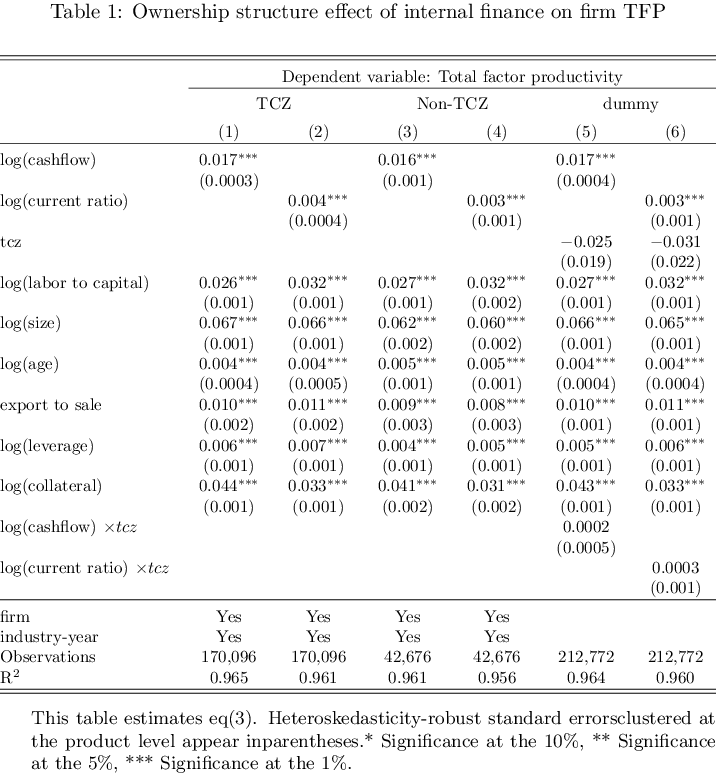

In [33]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'TCZ': 2,
    'Non-TCZ': 2,
    'dummy':2
}
reorder = {
    9:3,
    #10:3,
}
#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 7: City characteristic effect of external credit demand on firm productivity

In [34]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [35]:
%get path table 
## Credit supply
t_0 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            supply_all_credit *tcz+
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            supply_long_term_credit *tcz+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            supply_all_credit *tcz+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
t_3 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            supply_long_term_credit*tcz +
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
## Credit demand
t_4 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            credit_constraint *tcz+
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year |0 | firm, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            credit_constraint *tcz+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year|0 | firm, df_final,
            exactDOF = TRUE)
dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4,t_5
),
    title="City characteristic TCZ effect of external credit demand on firm TFP",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

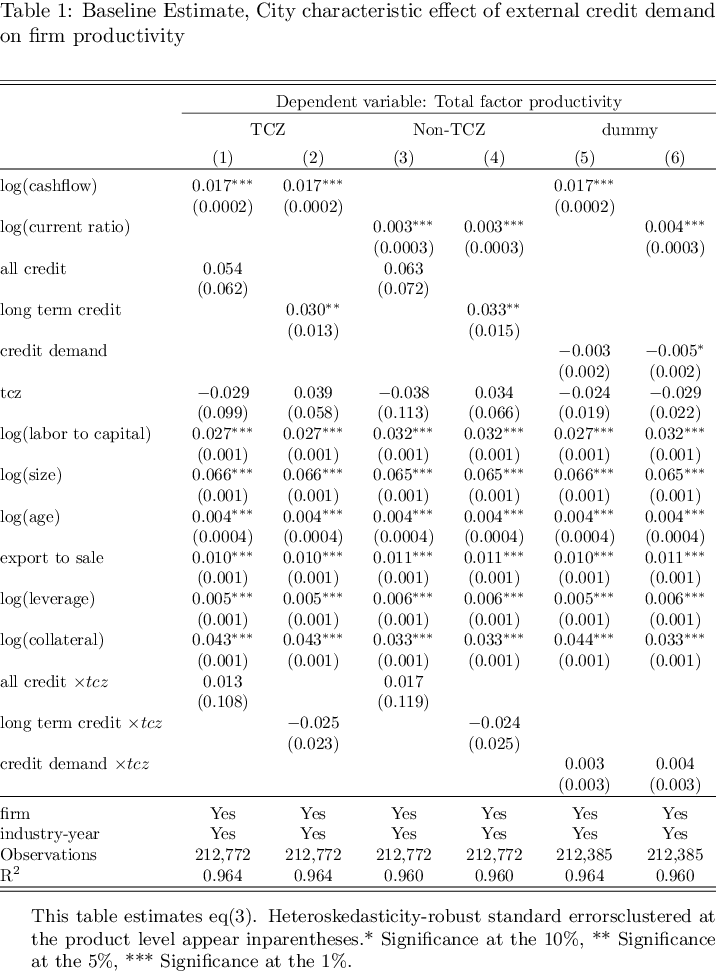

In [36]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'TCZ': 2,
    'Non-TCZ': 2,
    'dummy':2
}
reorder = {
    9:3,
    #10:3,
}
#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 8: City characteristic SPZ effect of internal finance on firm TFP

In [37]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [38]:
%get path table 
### SOE
t_0 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(spz == 1),
            exactDOF = TRUE)
t_1 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(spz == 1),
            exactDOF = TRUE)
### Private
t_2 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(spz == 0),
            exactDOF = TRUE)
t_3 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final %>% filter(spz == 0),
            exactDOF = TRUE)
t_4 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) * spz+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
t_5 <- felm(log(tfp_op) ~ 
            log(current_ratio)*spz + 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4, t_5
),
    title="City characteristic SPZ effect of internal finance on firm TFP",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

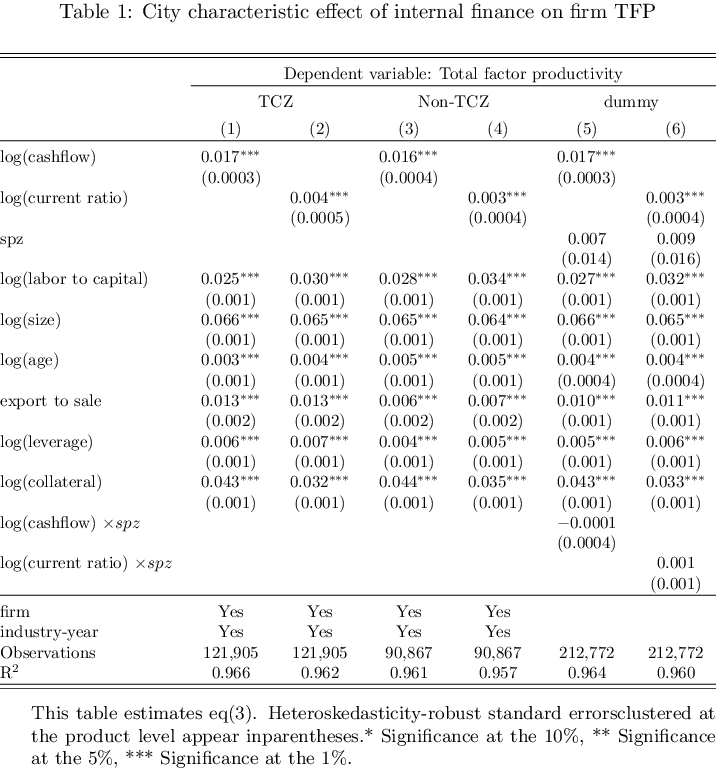

In [39]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'TCZ': 2,
    'Non-TCZ': 2,
    'dummy':2
}
reorder = {
    9:3,
    #10:3,
}
#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 9: City characteristic SPZ effect of external credit demand on firm productivity

In [40]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [41]:
%get path table 
## Credit supply
t_0 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            supply_all_credit *spz+
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            supply_long_term_credit *spz+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            supply_all_credit *spz+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
t_3 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            supply_long_term_credit*spz +
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
## Credit demand
t_4 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) + 
            credit_constraint *spz+
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset) 
            | firm + year |0 | firm, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tfp_op) ~ 
            log(current_ratio) + 
            credit_constraint *spz+ 
            log(labor_capital) +
            log(total_asset) + 
            log(age) +
            export_to_sale +
            log(liabilities_tot_asset) +
            log(asset_tangibility_tot_asset)
            | firm + year|0 | firm, df_final,
            exactDOF = TRUE)
dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4,t_5
),
    title="City characteristic SPZ effect of external credit demand on firm TFP",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

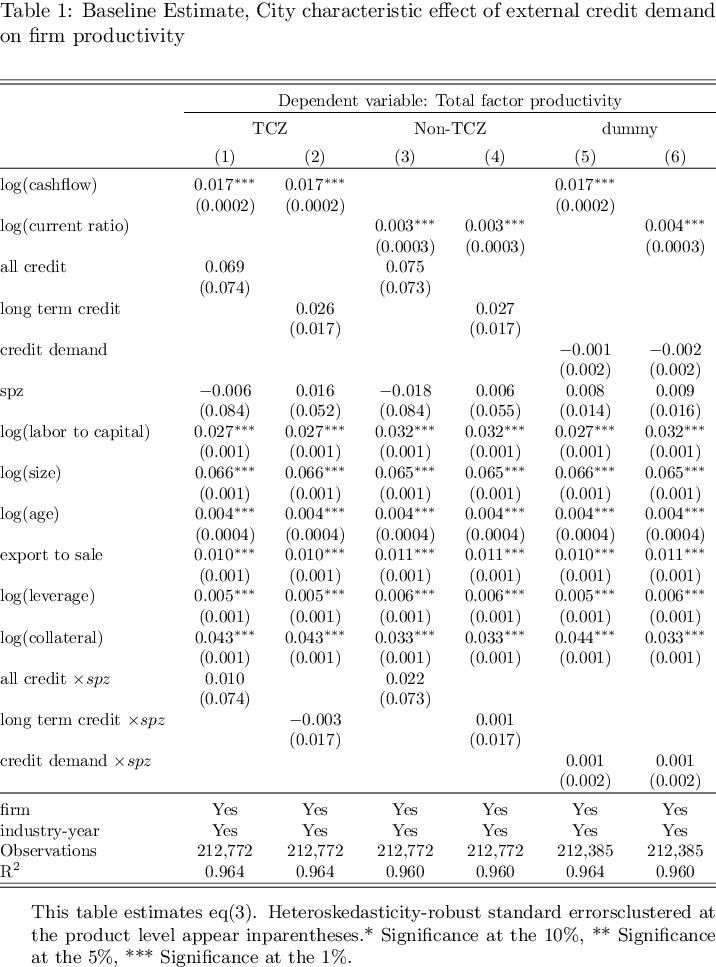

In [42]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'TCZ': 2,
    'Non-TCZ': 2,
    'dummy':2
}
reorder = {
    9:3,
    #10:3,
}
#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

# Previous results

## Table 1: Baseline Estimate, tfp_OP_f

$$ \begin{aligned} \text { TFP }_{f i t}= \delta{6} \text { Tangible Asset }_{fit} + \delta{7} \text { Current Ratio }_{fit}+\delta{8} \text { Cash/Assets }_{fit}+\delta{9} \text { Liabilities/Assets }_{fit}+\Lambda{\text {fit}}^{\prime} X+\vartheta_{i t}+u_{\text {fit}} \end{aligned} $$


* Column 1: Baseline
    * FE: 
        - fe 1: `firm`
        - fe 2: `industry-year`
* Column 2: Add control
    * FE: 
        - fe 1: `firm`
        - fe 2: `industry-year`
* Column 3: Test credit constraint interaction
    * FE: 
        - fe 1: `firm`
        - fe 2: `industry-year`

In [13]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [14]:
%get path table 
t_0 <- felm(log(tfp_op) ~ 
            log(asset_tangibility_tot_asset) + 
            log(current_ratio) +
            log(cashflow_to_tangible) +
            log(liabilities_tot_asset)
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(tfp_op) ~ 
            log(asset_tangibility_tot_asset) + 
            log(current_ratio) +
            log(cashflow_to_tangible) +
            log(liabilities_tot_asset) +
            log(sales_tot_asset) 
            | firm + year + indu_2 |0 | firm,df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tfp_op) ~ 
            log(asset_tangibility_tot_asset) + 
            log(current_ratio) +
            log(cashflow_to_tangible) +
            log(liabilities_tot_asset) +
            log(sales_tot_asset) +
            log(current_ratio) * d_credit_constraint  + 
            log(cashflow_to_tangible) * d_credit_constraint + 
            log(liabilities_tot_asset) * d_credit_constraint
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2
),
    title="Baseline Estimate, determinants of firm-level TFP",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

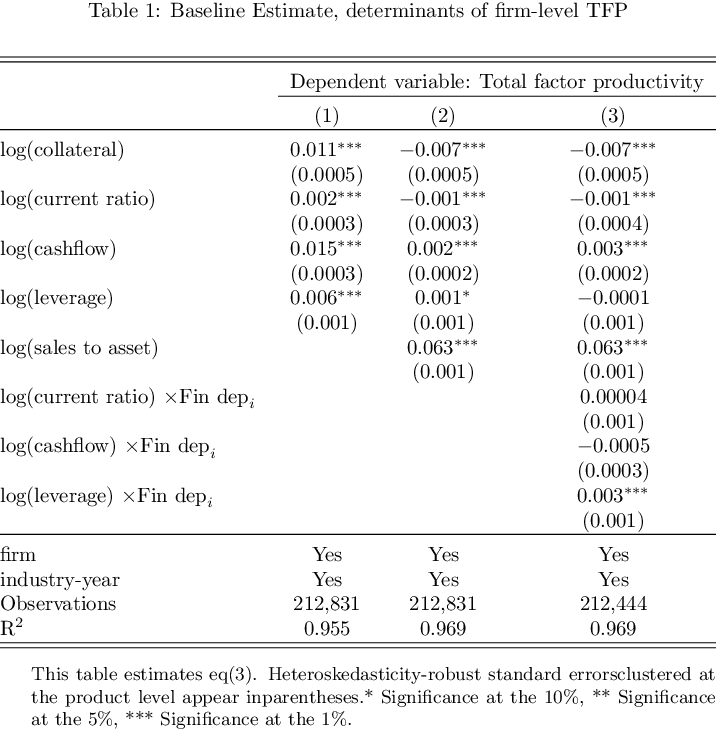

In [15]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 2: Separate estimate

In [16]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [17]:
%get path table 
t_0 <- felm(log(tfp_op) ~ 
            log(asset_tangibility_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(tfp_op) ~ 
            log(current_ratio) 
            | firm + year + indu_2 |0 | firm,df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
            
t_3 <- felm(log(tfp_op) ~ 
            log(liabilities_tot_asset) 
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

### interaction
t_4 <- felm(log(tfp_op) ~ 
            log(asset_tangibility_tot_asset) * d_credit_constraint
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tfp_op) ~ 
            log(current_ratio) * d_credit_constraint
            | firm + year + indu_2 |0 | firm,df_final,
            exactDOF = TRUE)

t_6 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) * d_credit_constraint
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
            
t_7 <- felm(log(tfp_op) ~ 
            log(liabilities_tot_asset) * d_credit_constraint
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4,t_5, t_6, t_7
),
    title="Baseline Estimate, determinants of firm-level TFP",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

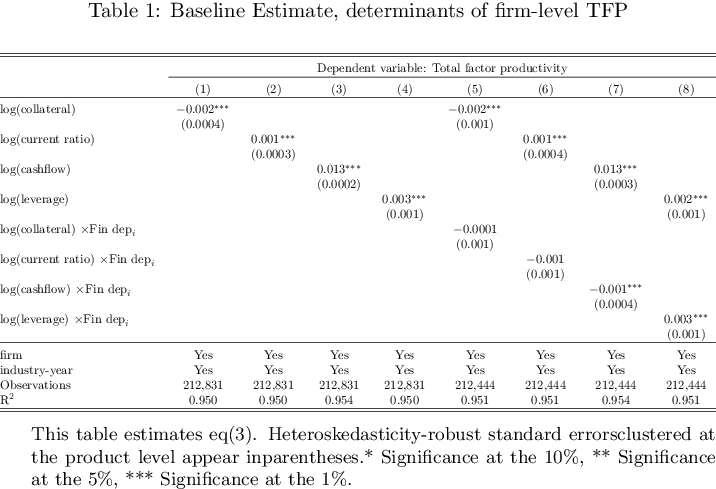

In [18]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 3: Private vs SOE

In [21]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [22]:
%get path table
t_0 <- felm(log(tfp_op) ~ 
            log(asset_tangibility_tot_asset) * soe_vs_pri
            |firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(tfp_op) ~ 
            log(current_ratio) * soe_vs_pri
            | firm + year + indu_2 |0 | firm,df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) * soe_vs_pri
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
            
t_3 <- felm(log(tfp_op) ~ 
            log(liabilities_tot_asset) * soe_vs_pri
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_4 <- felm(log(tfp_op) ~ 
            log(current_ratio) * soe_vs_pri +
            log(cashflow_to_tangible) * soe_vs_pri +
            log(liabilities_tot_asset) * soe_vs_pri
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tfp_op) ~ 
            log(asset_tangibility_tot_asset) * soe_vs_pri +
            log(current_ratio) * soe_vs_pri +
            log(cashflow_to_tangible) * soe_vs_pri +
            log(liabilities_tot_asset) * soe_vs_pri
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

dep <- "Dependent variable: Total factor productivity"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4, t_5
),
    title="Baseline Estimate, determinants of firm-level TFP (SOE vs PRI)",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

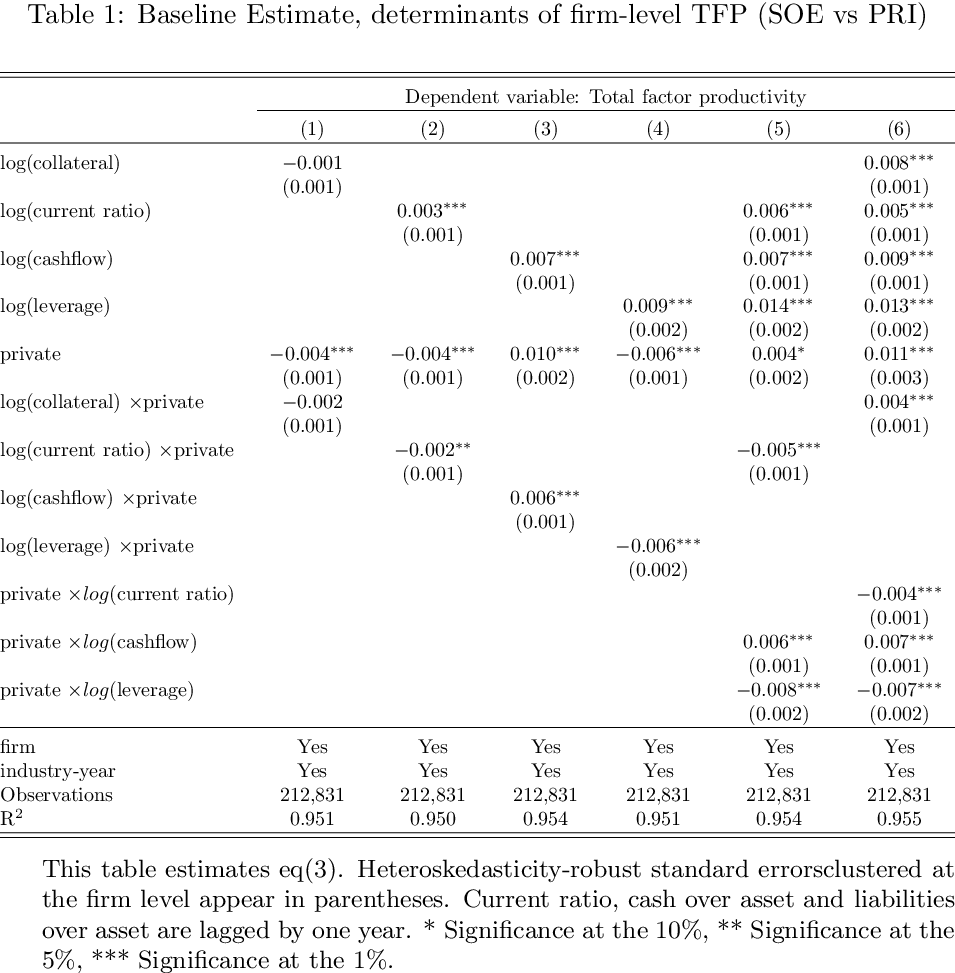

In [23]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the firm level appear in parentheses."\
" Current ratio, cash over asset and liabilities over asset are lagged by one year. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

## Table 4: TCZ

In [24]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [25]:
%get path table
t_0 <- felm(log(tfp_op) ~ 
            log(asset_tangibility_tot_asset) * tcz
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(tfp_op) ~ 
            log(current_ratio) * tcz
            | firm + year + indu_2 |0 | firm,df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) * tcz
            |firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
            
t_3 <- felm(log(tfp_op) ~ 
            log(liabilities_tot_asset) * tcz
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_4 <- felm(log(tfp_op) ~ 
            log(current_ratio) * tcz +
            log(cashflow_to_tangible) * tcz +
            log(liabilities_tot_asset) * tcz
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tfp_op) ~ 
            log(current_ratio) * tcz +
            log(current_ratio) * tcz +
            log(cashflow_to_tangible) * tcz +
            log(liabilities_tot_asset) * tcz
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
            
dep <- "Dependent variable: TFP"
fe1 <- list(
    c("firm", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Baseline Estimate, determinants of firm-level TFP (TCZ)",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

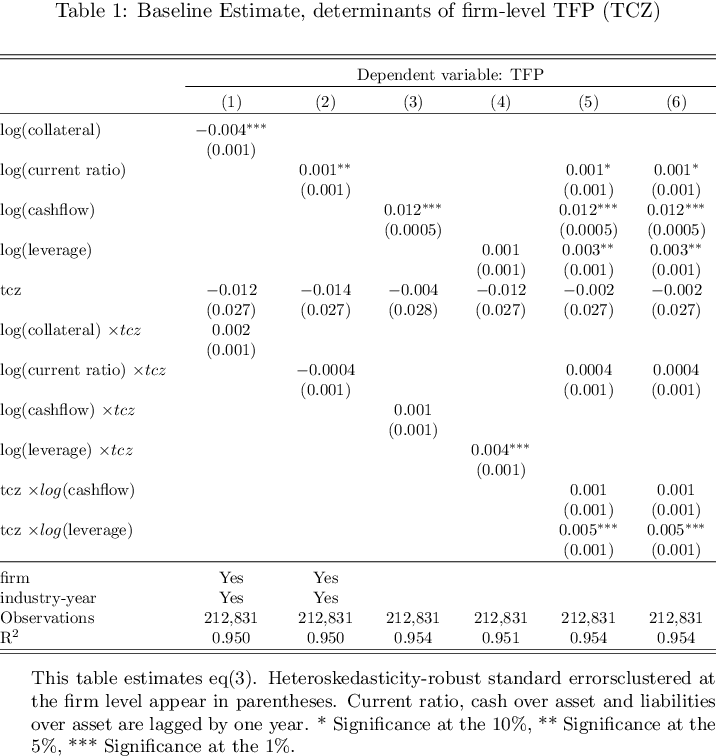

In [26]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the firm level appear in parentheses."\
" Current ratio, cash over asset and liabilities over asset are lagged by one year. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 5: SPZ

In [27]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [28]:
%get path table
t_0 <- felm(log(tfp_op) ~ 
            log(asset_tangibility_tot_asset) * spz
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(tfp_op) ~ 
            log(current_ratio) * spz
            | firm + year + indu_2 |0 | firm,df_final,
            exactDOF = TRUE)

t_2 <- felm(log(tfp_op) ~ 
            log(cashflow_to_tangible) * spz
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
            
t_3 <- felm(log(tfp_op) ~ 
            log(liabilities_tot_asset) * spz
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_4 <- felm(log(tfp_op) ~ 
            log(current_ratio) * spz +
            log(cashflow_to_tangible) * spz +
            log(liabilities_tot_asset) * spz
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(tfp_op) ~ 
            log(asset_tangibility_tot_asset) * spz +
            log(current_ratio) * spz +
            log(cashflow_to_tangible) * spz +
            log(liabilities_tot_asset) * spz
            | firm + year + indu_2|0 | firm, df_final,
            exactDOF = TRUE)
            
dep <- "Dependent variable: TFP"
fe1 <- list(
    c("firm", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Baseline Estimate, determinants of firm-level TFP (TCZ)",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

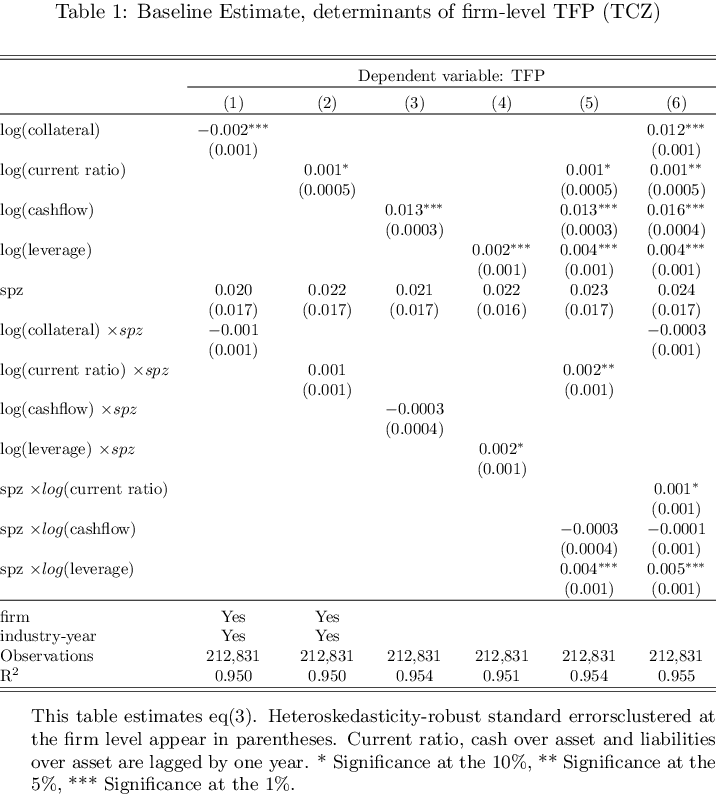

In [29]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the firm level appear in parentheses."\
" Current ratio, cash over asset and liabilities over asset are lagged by one year. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder)

## Table 6: Large vs Small

In [ ]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get folder
t <- 1
for (var in list(
    #'size_asset_',
    'size_output_',
    'size_employment_',
    'size_capital_',
    'size_sales_'
    )){
    
    for (option in list('fci','fc','fi')){
        
        variable <- paste0(var, option)
        
        title <- paste0("Baseline Estimate, determinants of firm-level TFP (", var, option, ")")
        path_1 <- paste0(folder,"/table_",t ,".txt")
        t_0 <- felm(log(tfp_op) ~ 
                log(current_ratio) * d_size_percentile  + 
                log(cashflow_to_tangible) * d_size_percentile + 
                log(liabilities_tot_asset) * d_size_percentile
                | firm + year + indu_2|0 | firm, df_final %>% 
    mutate(d_size_percentile = str_extract(get(variable), "(?<=.5\\=)(.*?)(?=\\,)")),
                exactDOF = TRUE)

    t_1 <- felm(log(tfp_op) ~ 
                    log(current_ratio) * d_size_percentile  + 
                log(cashflow_to_tangible) * d_size_percentile + 
                log(liabilities_tot_asset) * d_size_percentile
                    |firm + year + indu_2|0 | firm, df_final %>% 
        mutate(d_size_percentile = str_extract(get(variable), "(?<=.75\\=)(.*?)(?=\\,)")),
                    exactDOF = TRUE)

    t_2 <- felm(log(tfp_op) ~ 
                    log(current_ratio) * d_size_percentile  + 
                log(cashflow_to_tangible) * d_size_percentile + 
                log(liabilities_tot_asset) * d_size_percentile
                    | firm + year + indu_2|0 | firm, df_final %>% 
        mutate(d_size_percentile = str_extract(get(variable), "(?<=.9\\=)(.*?)(?=\\,)")),
                    exactDOF = TRUE)

    t_3 <- felm(log(tfp_op) ~ 
                    log(current_ratio) * d_size_percentile  + 
                log(cashflow_to_tangible) * d_size_percentile + 
                log(liabilities_tot_asset) * d_size_percentile
                    | firm + year + indu_2|0 | firm, df_final %>% 
        mutate(d_size_percentile = str_extract(get(variable), "(?<=.95\\=)(.*?)(?=\\})")),
                    exactDOF = TRUE)

    dep <- "Dependent variable: TFP"
    fe1 <- list(
            c("firm", "Yes", "Yes", "Yes", "Yes"),
            c("industry-year", "Yes", "Yes", "Yes", "Yes")
                     )
    table_1 <- go_latex(
        list(t_0,t_1, t_2, t_3),
        title=title,
        dep_var = dep,
        addFE=fe1,
        save=TRUE,
        note = FALSE,
        name=path_1
        )
        t<- t + 1
    }
}

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the firm level appear in parentheses."\
" Current ratio, cash over asset and liabilities over asset are lagged by one year. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& .5', '.75', '.90', '.95']
for i in range(1, 16):
    print('\n\nTable {}\n\n'.format(i))
    lb.beautify(table_number = i,
                #reorder_var = reorder,
                #multi_lines_dep = multi_lines_dep,
                new_row= new_r,
                #multicolumn = multicolumn,
                table_nte = tbe1,
                jupyter_preview = True,
                resolution = 200,
                folder = folder)

In [ ]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [ ]:
def create_report(extension = "html", keep_code = False, notebookname = None):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            notebookname = notebookname  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = False, notebookname = "05_tfp_firm_level.ipynb")